**HIERARCHICAL CLUSTERING**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet,fcluster,inconsistent
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [ ]:
df_hierarchical= pd.read_csv("/content/hierarchical dataset responsi.csv")

In [ ]:
df_hierarchical.head()

,Unnamed: 0,dim1,dim2
0,0,9.925071,0.554242
1,1,-2.031917,-0.802822
2,2,-4.624159,-9.173519
3,3,9.074243,0.855616
4,4,-4.706691,-8.297154


<ipython-input-7-91d20963ae9a>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_hierarchical, x='dim1', y='dim2', palette='tab10')


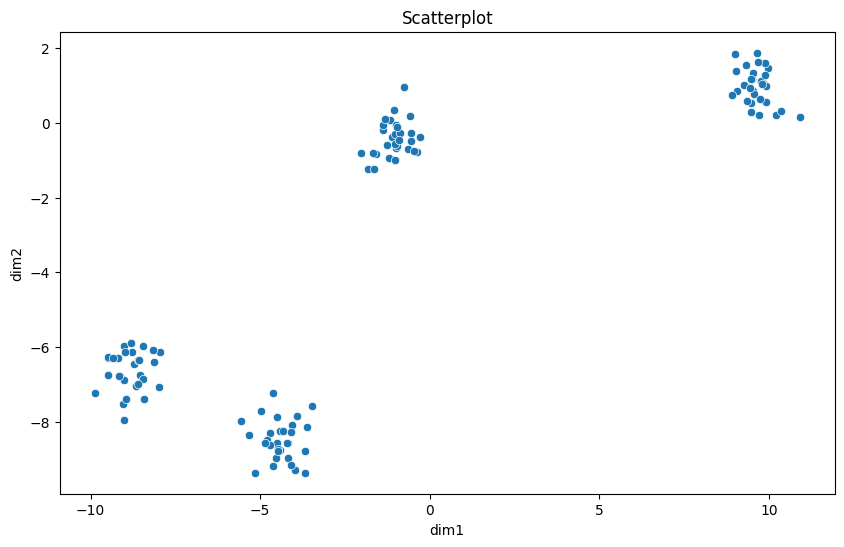

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_hierarchical, x='dim1', y='dim2', palette='tab10')
plt.title('Scatterplot')
plt.xlabel('dim1')
plt.ylabel('dim2')

plt.show()

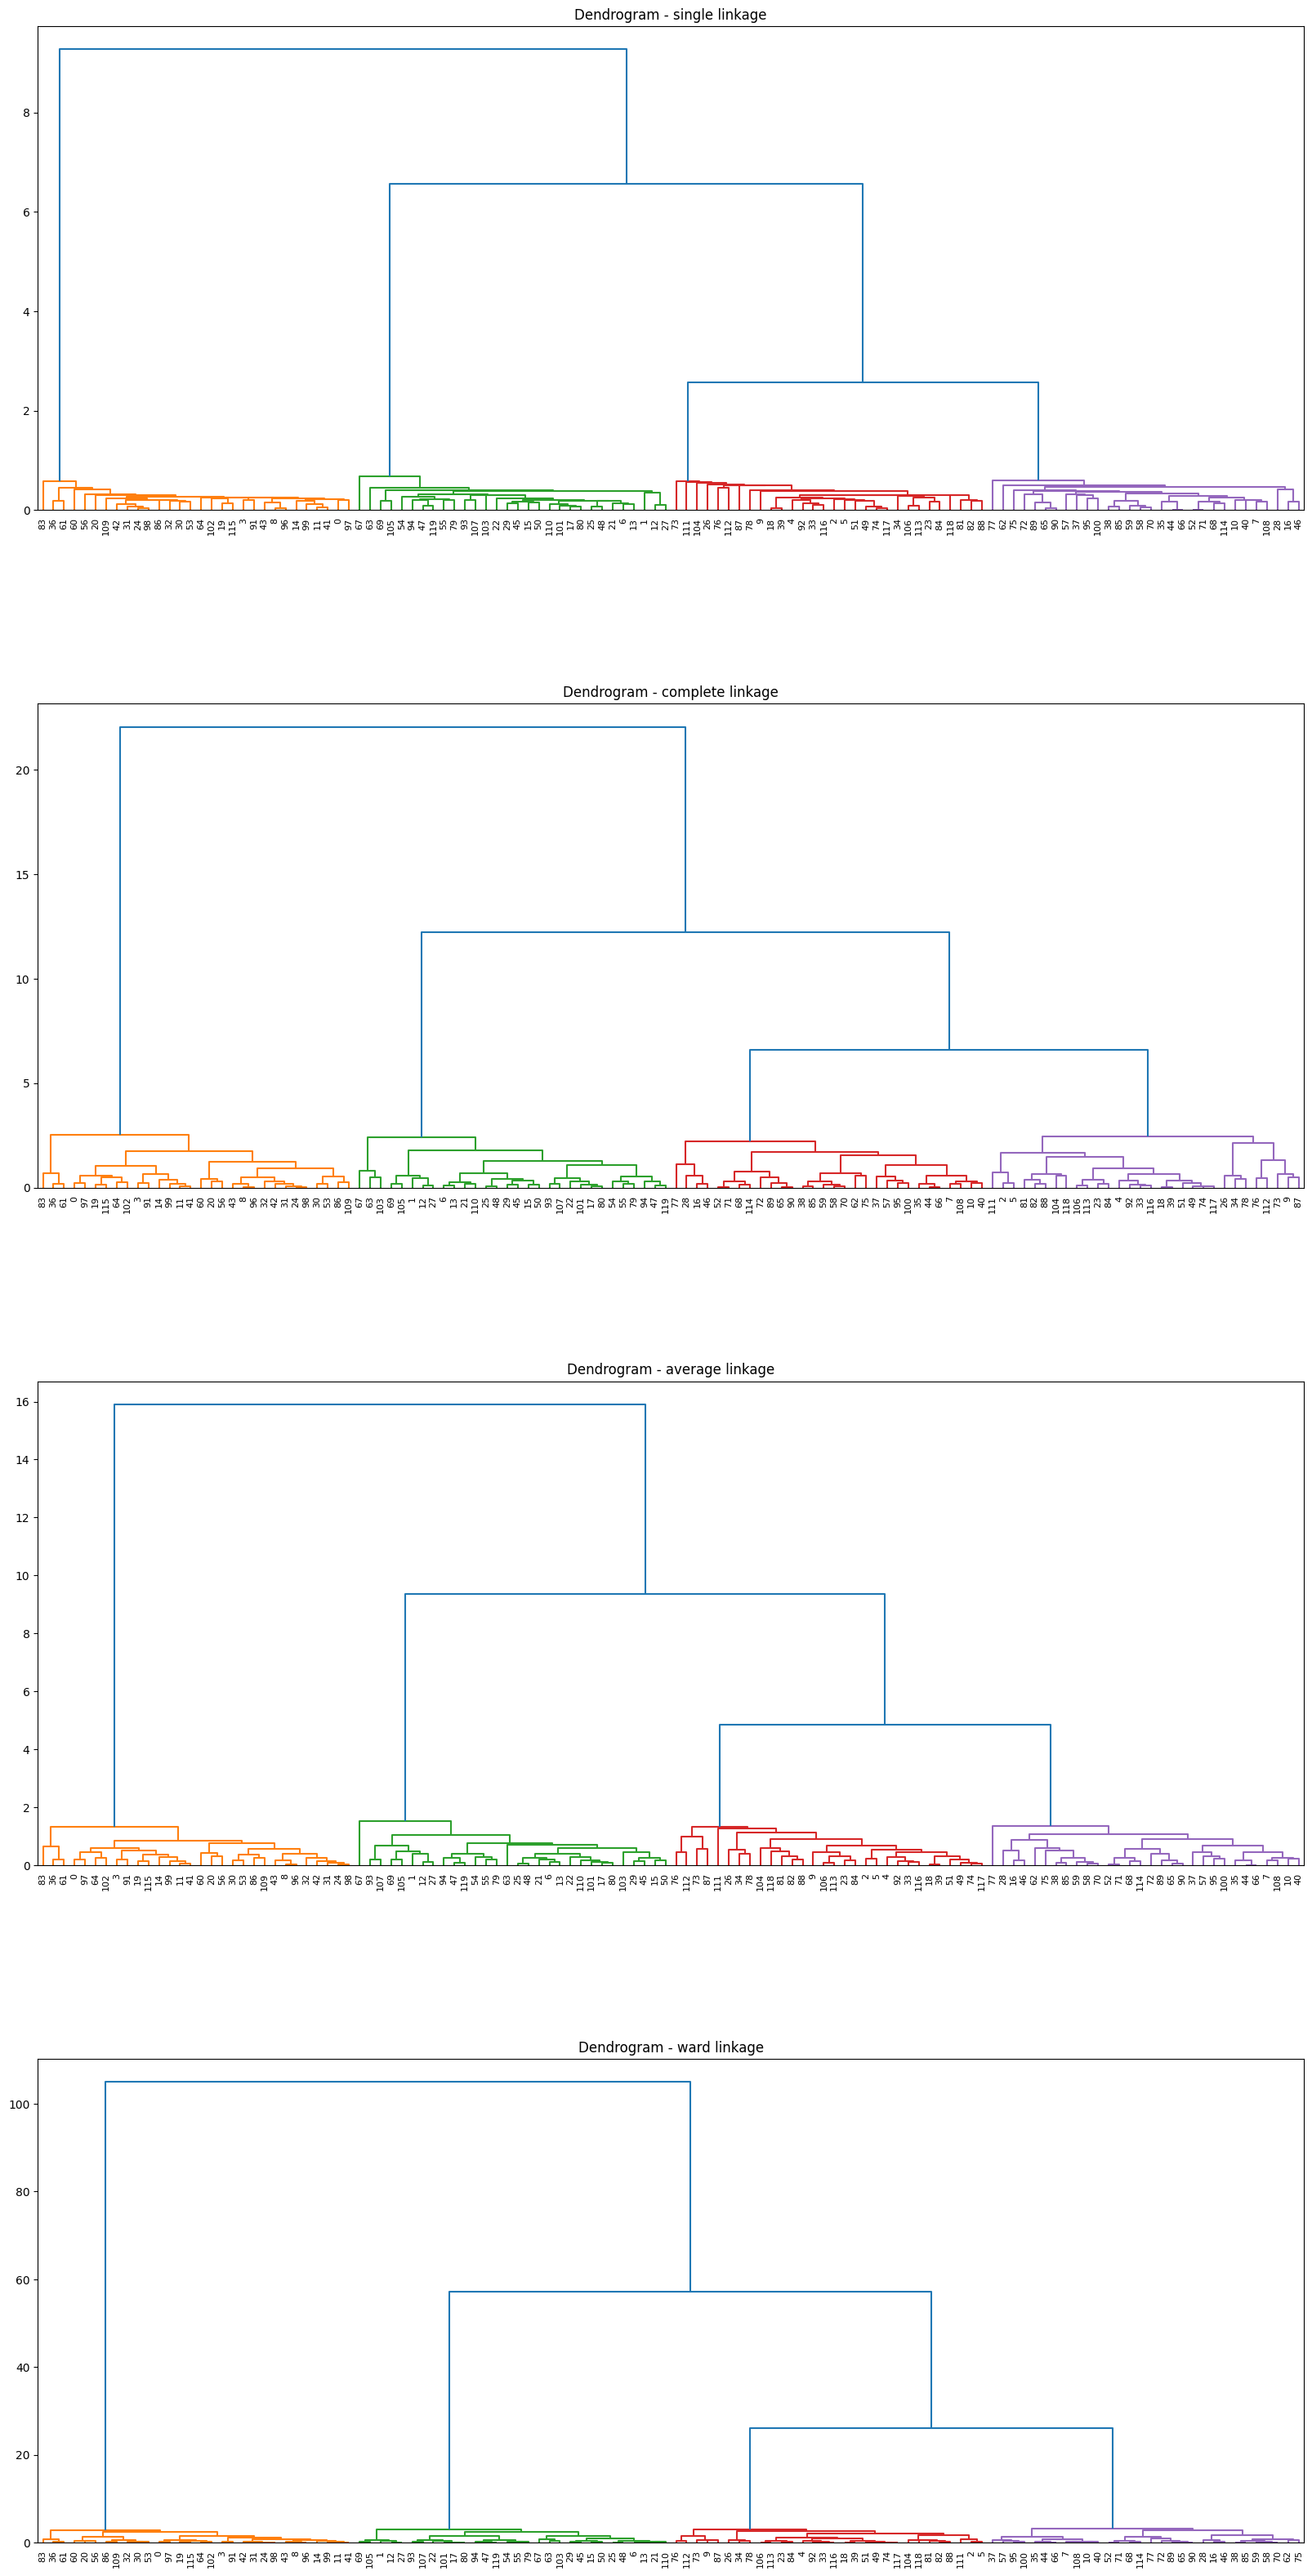

In [ ]:
# Create list of method
metode_lib = [('single' , 1), ('complete',4), ('average',4), ('ward',10)]

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(20,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Create Dendogram for each method
for i, (metode, color) in enumerate(metode_lib):
    linkage_matrix = linkage(df_hierarchical[['dim1', 'dim2']], method=metode)
    ax = axs[i]
    dendrogram(linkage_matrix, ax=ax, color_threshold=color, labels=df_hierarchical['Unnamed: 0'].to_numpy(), leaf_font_size=8)
    ax.set_title(f'Dendrogram - {metode} linkage')

# Show the Graph
plt.show()

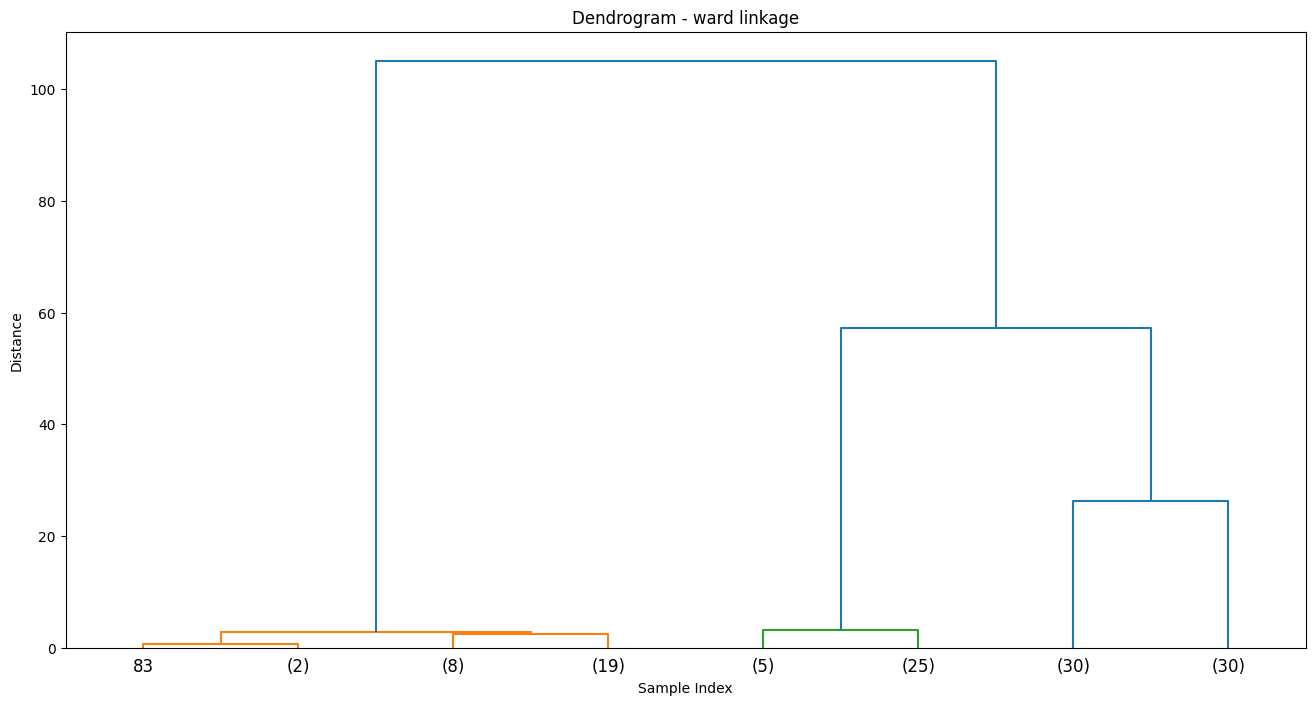

In [ ]:
linkage_matrix = linkage(df_hierarchical[['dim1', 'dim2']], method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, color_threshold=4, truncate_mode="level", p=2)
plt.title('Dendrogram - ward linkage')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
def cophenetic_corr(linkage_matrix, data_mtx, distance_measure='euclidean'):

    if distance_measure != 'precomputed':
        cop_corr = cophenet(
            linkage_matrix,
            pdist(data_mtx, metric=distance_measure),
        )[0]

    else:
        cop_corr = cophenet(
            linkage_matrix,
            squareform(data_mtx),
        )[0]
    return cop_corr

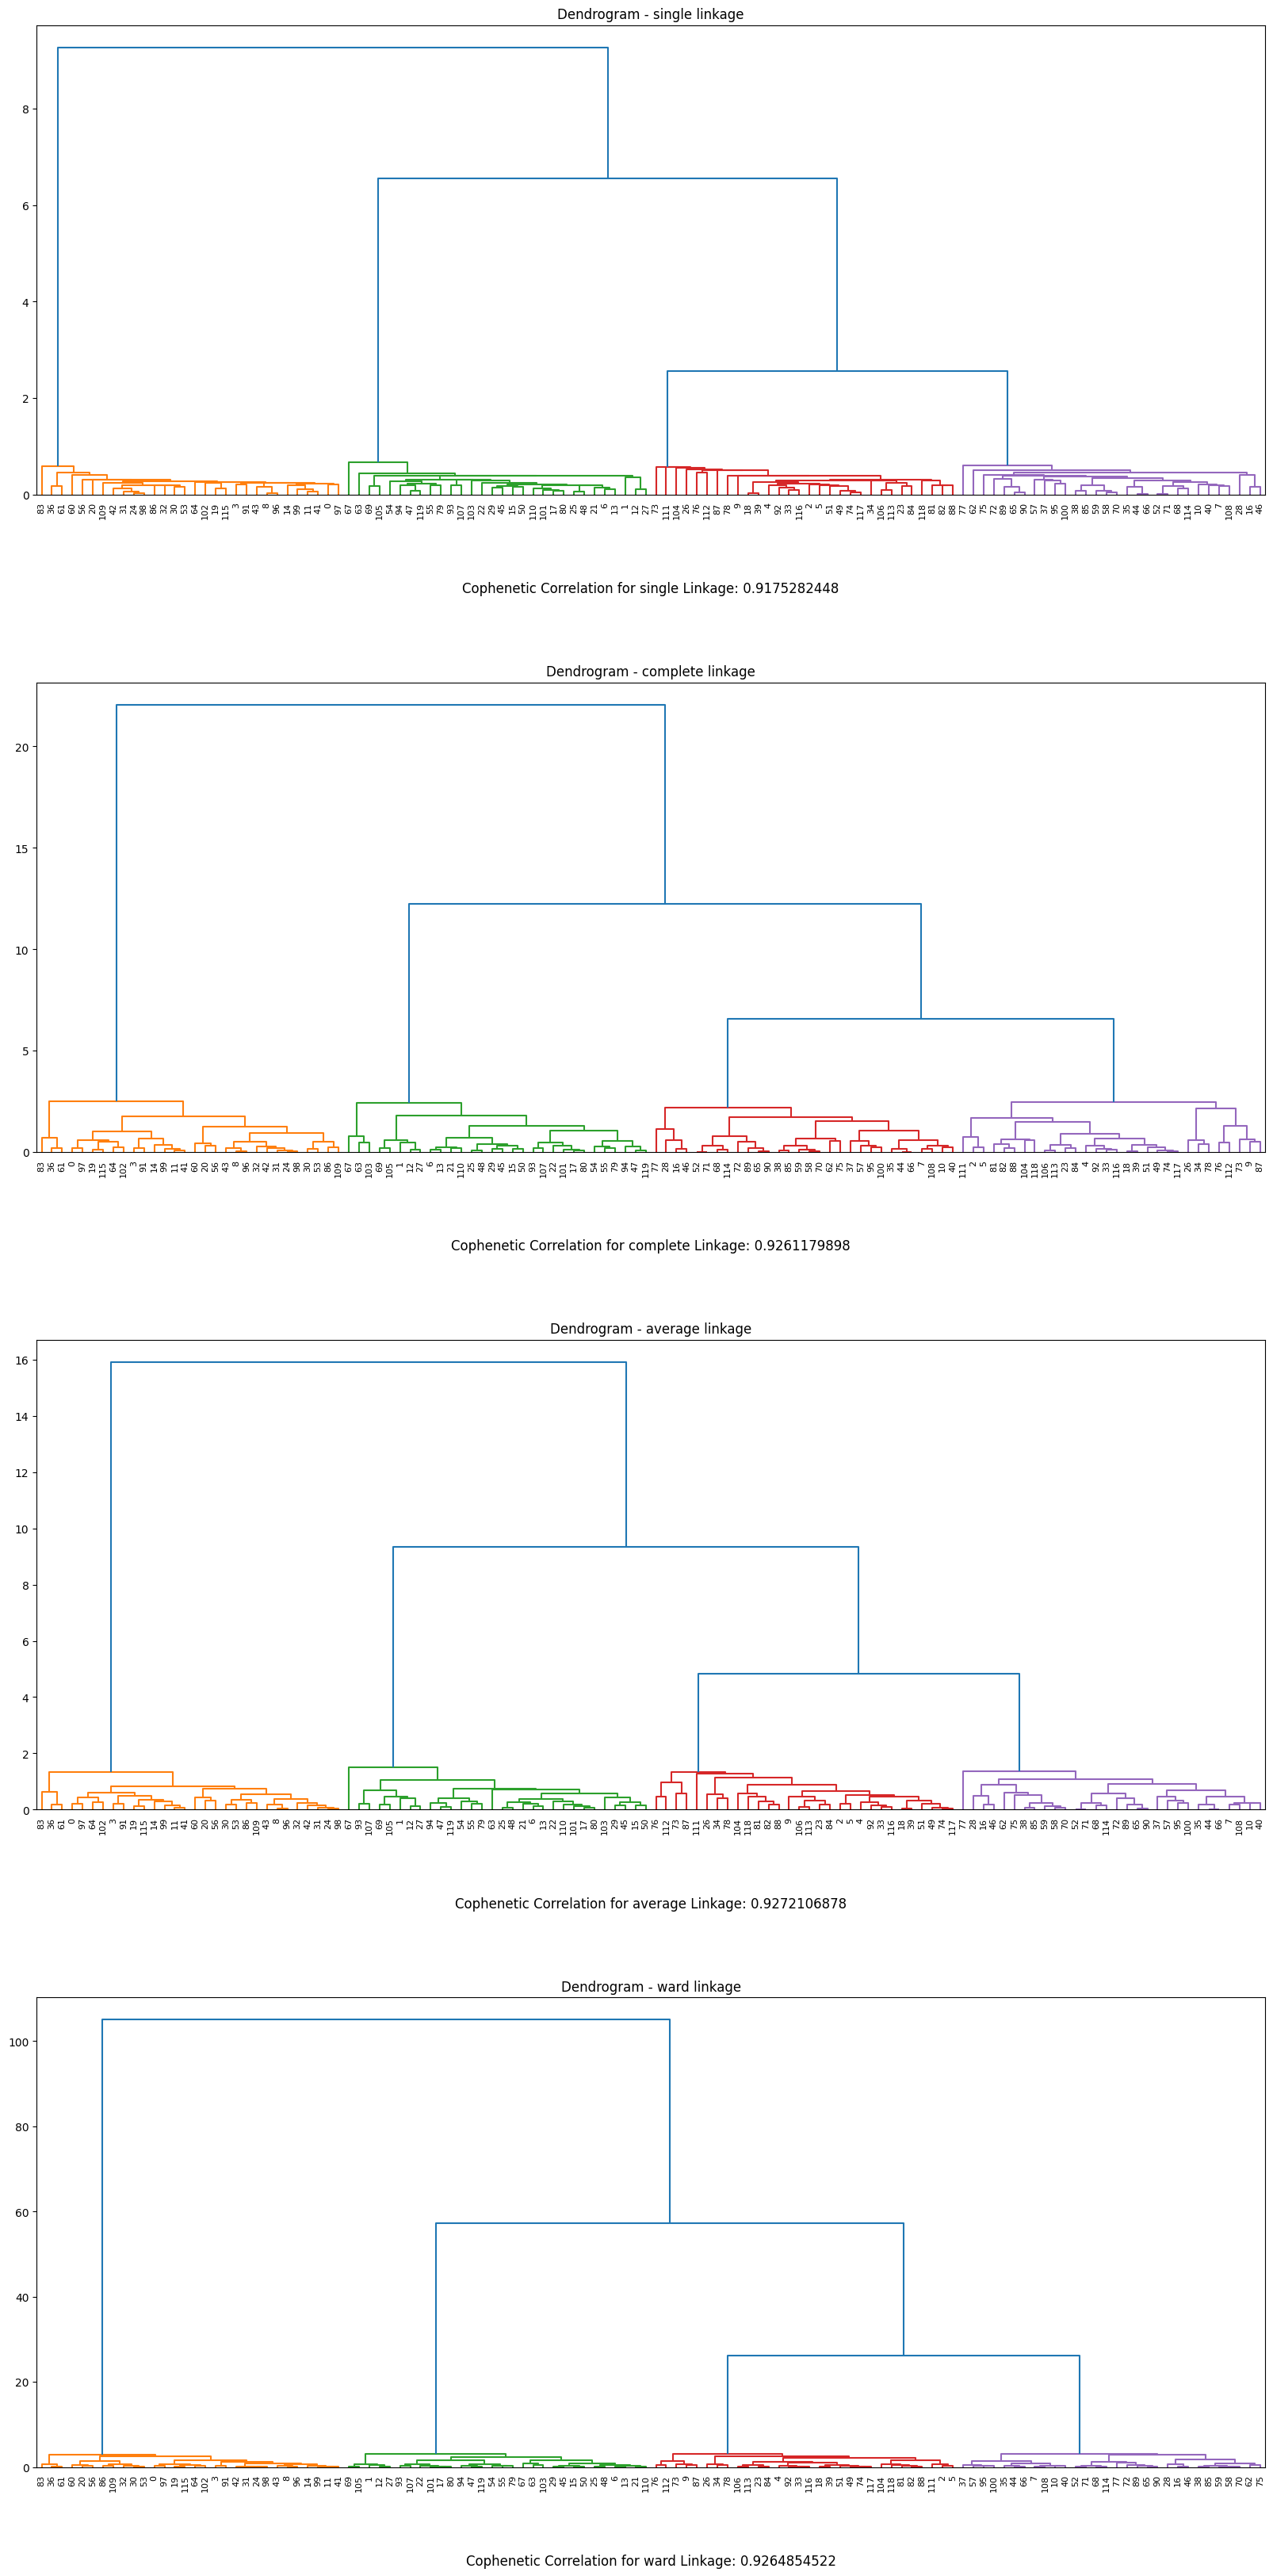

In [ ]:
# Create list of method
metode_lib = [('single', 1), ('complete', 4), ('average', 4), ('ward', 10)]

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Create Dendogram for each method
for i, (metode, color) in enumerate(metode_lib):
    linkage_matrix = linkage(df_hierarchical[['dim1', 'dim2']], method=metode)
    Corr = cophenetic_corr(linkage_matrix, df_hierarchical[['dim1', 'dim2']].to_numpy())
    ax = axs[i]
    dendrogram(linkage_matrix, ax=ax, color_threshold=color, labels=df_hierarchical['Unnamed: 0'].to_numpy(), leaf_font_size=8)
    ax.set_title(f'Dendrogram - {metode} linkage')
    ax.text(0.5, -0.2, f'Cophenetic Correlation for {metode} Linkage: {Corr:.10f}', ha='center', va='center', transform=ax.transAxes, fontsize=12)

# Show the graph
plt.show()

Height-cut method

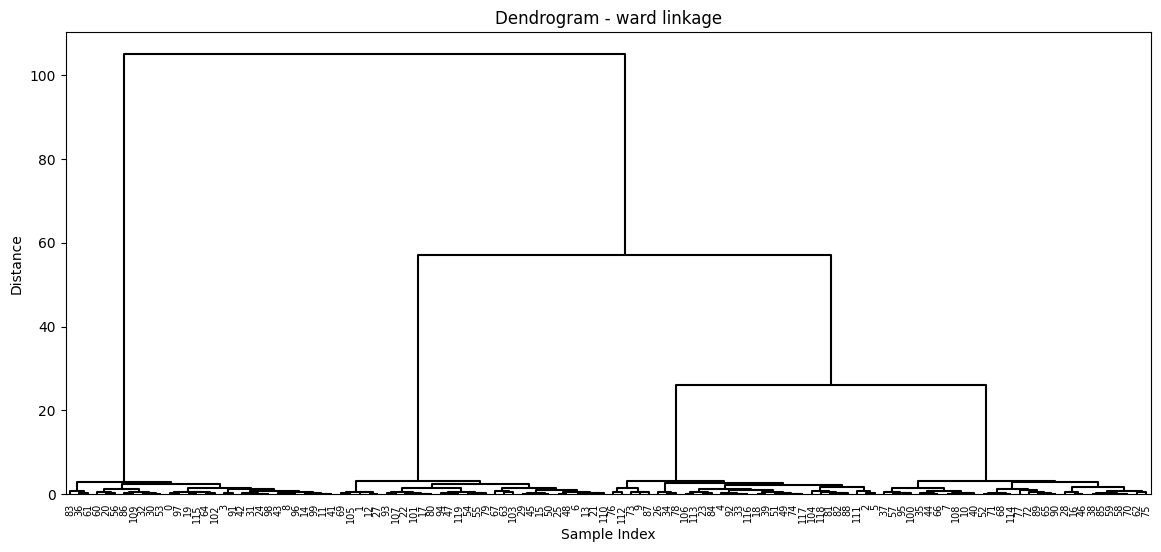

In [ ]:
#Search Linkage Matrix by using ward linkage
linkage_matrix = linkage(df_hierarchical[['dim1', 'dim2']], method='ward')

# Draw the dendrogram
plt.figure(figsize=(14, 6))
_ = dendrogram(
    linkage_matrix,
    leaf_font_size=7,
    labels=df_hierarchical['Unnamed: 0'].to_numpy(),  # Use label from 'Unnamed: 0'
    above_threshold_color='black',
    color_threshold=0
)
plt.title('Dendrogram - ward linkage')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
# Cluster by using cut_height
cut_height = 13
clusters = fcluster(linkage_matrix, criterion='distance', t=cut_height)

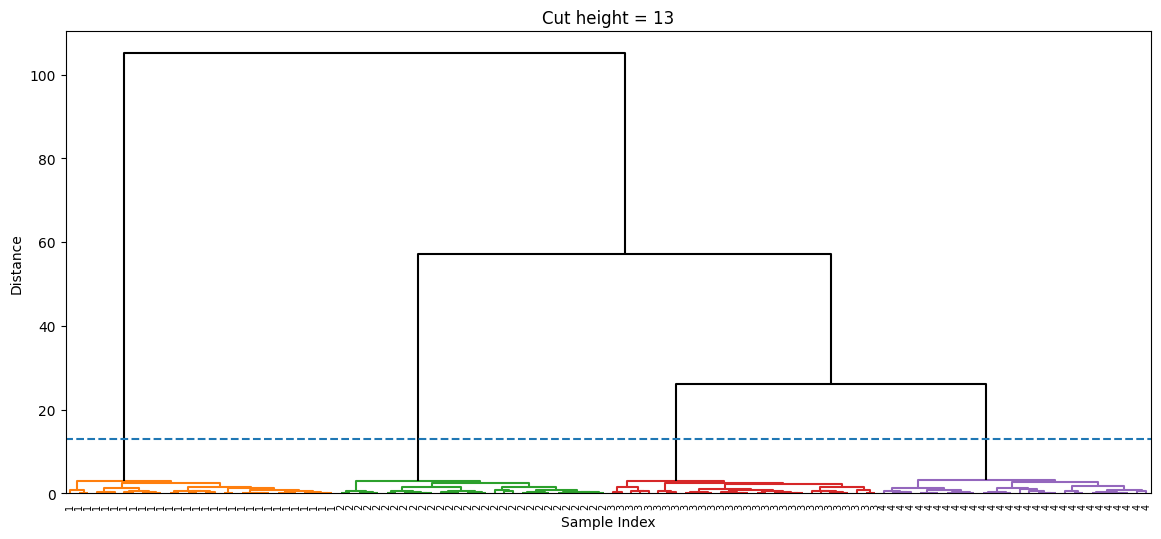

In [ ]:
# Draw the dendrogram
plt.figure(figsize=(14, 6))
_ = dendrogram(
    linkage_matrix,
    leaf_font_size=7,
    labels=clusters,
    above_threshold_color='black',
    color_threshold=cut_height
)
plt.hlines(cut_height, xmin=-100, xmax=10000, linestyles='--')
plt.title('Cut height = 13')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

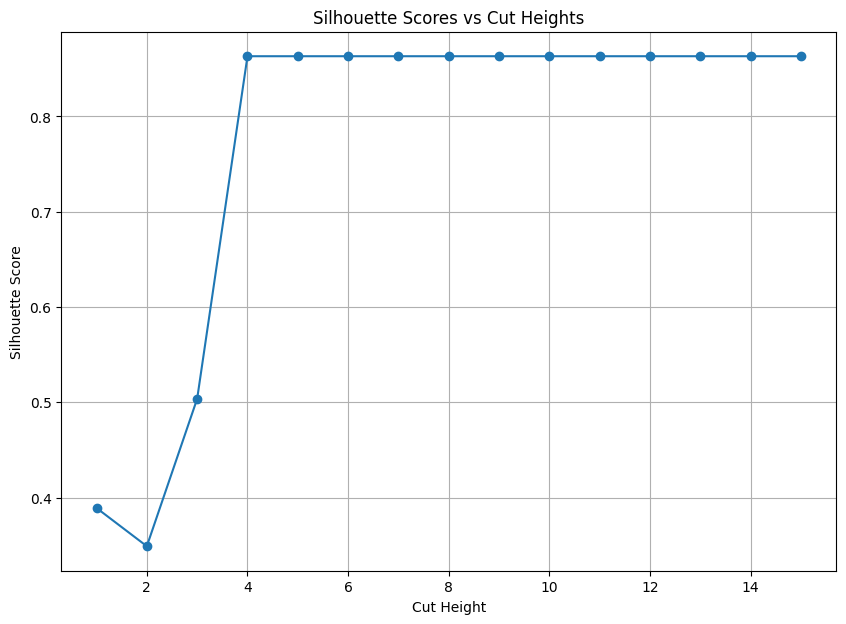

In [ ]:
# Initialize list to store Silhouette Scores
silhouette_scores = []

# Range of cut heights to test
cut_heights = range(1,16)

# LLoop through each cut height and calculate Silhouette Score
for cut_height in cut_heights:
    clusters = fcluster(linkage_matrix, criterion='distance', t=cut_height)
    if len(set(clusters)) > 1:  # Ensure there is more than one cluster
        score = silhouette_score(df_hierarchical[['dim1', 'dim2']], clusters)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # If only one cluster, Silhouette Score is not valid

# Plot Silhouette Scores vs Cut Heights
plt.figure(figsize=(10, 7))
plt.plot(cut_heights, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Cut Heights')
plt.xlabel('Cut Height')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Number of cluster method

In [ ]:
# Cluster based on the desired number of clusters
num_clusters = 2
clusters = fcluster(Z=linkage_matrix, t=num_clusters, criterion='maxclust')

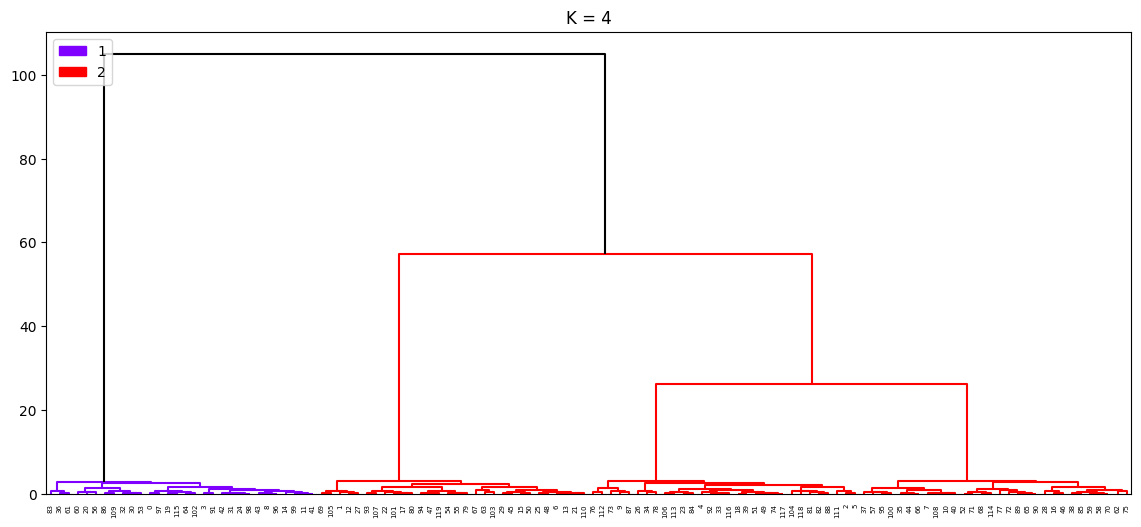

In [ ]:
# Get unique clusters
unique_clusters = np.unique(clusters)
# Get first two columns of linkage matrix (representing nodes in nodes)
trunc_linkage = linkage_matrix[:, :2].astype(np.int32)
# Get last "original" point ID
max_orig_point_id = df_hierarchical[['dim1', 'dim2']].shape[0]

# Initialize dict that will hold cluster-link relations
cluster_link_dict = {}

# Iterate through all the clusters
for clust in unique_clusters:

    # Get all points belonging to current cluster
    clust_points = np.where(clusters == clust)[0]

    # Iterate until we collect all nodes associated with current cluster
    while True:
        # Find all positions in linkage matrix where points from the current
        points_present = np.isin(trunc_linkage, clust_points)

        # Sum the matrix in order to find positions where
        # both points belong to current cluster
        present_points_sum = np.sum(points_present, axis=1)
        loc_of_twos = np.where(present_points_sum == 2)[0]

        # Get node locations
        nodes_to_add = list(loc_of_twos)

        # Variable that will be changed to True if new nodes are added to the dict
        added_new = False

        ## Iterate through the node
        for node in nodes_to_add:

            # Get true ids of the nodes
            node_pos = node + max_orig_point_id

            # Add new nodes
            if node_pos not in cluster_link_dict:
                added_new = True
                cluster_link_dict[node_pos] = clust

        # If no new nodes are added, this means that all
        # nodes associated with current cluster are already added.
        # In this case break current loop and proceed to the next cluster.
        if not added_new:
            break

         # Add merged nodes for next iteration
        new_clust_points = loc_of_twos + max_orig_point_id
        clust_points = np.concatenate([clust_points, new_clust_points])

# Get color palette having one color per cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
# Transform colors to hex format (dendrogram function requires it)
colors_hex = [plt.matplotlib.colors.rgb2hex(c) for c in colors]

color_dict = {key: colors_hex[cluster_link_dict[key] - 1] for key in cluster_link_dict}

link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

patches = [
    mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i]))
    for i in range(len(colors_hex))
]

plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    link_color_func=link_color_func,
    orientation='top',
    labels=df_hierarchical.index
)
plt.legend(handles=patches, loc='upper left')
plt.title('K = 4')
plt.show()

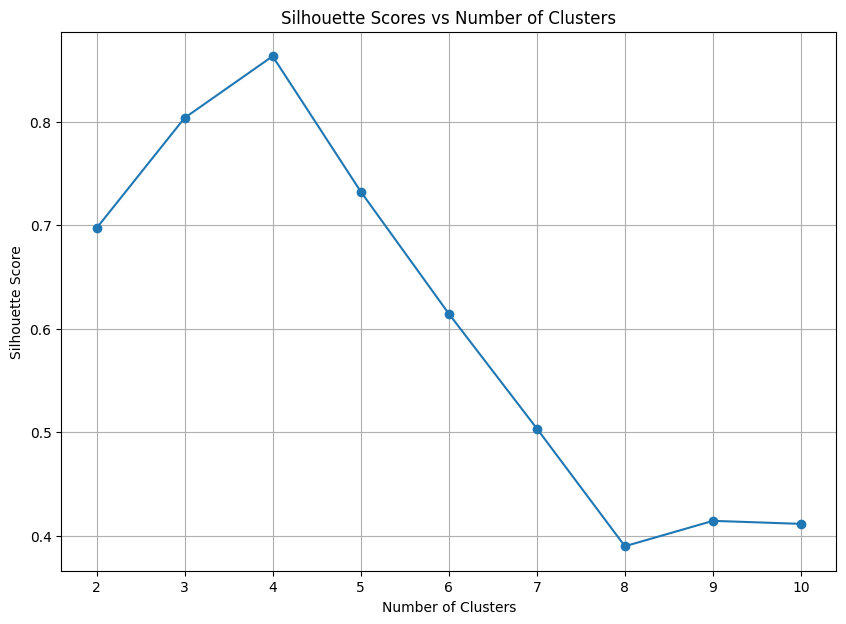

In [ ]:
# Initialize list to store Silhouette Scores
silhouette_scores = []

# Range of number cluster to test
num_clusters = range(2, 11)  # Update range to test more cluster sizes

# Loop through each number of clusters and calculate Silhouette Score
for num_cluster in num_clusters:
    clusters = fcluster(Z=linkage_matrix, t=num_cluster, criterion='maxclust')
    if len(set(clusters)) > 1:  # Ensure there is more than one cluster
        score = silhouette_score(df_hierarchical[['dim1', 'dim2']], clusters)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # If only one cluster, Silhouette Score is not valid

# Plot Silhouette Scores vs Number of Clusters
plt.figure(figsize=(10, 7))
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Inconsistency Method

In [ ]:
depth=3
incosistent_mtx = inconsistent(linkage_matrix, depth)

In [ ]:
inconsistency_df = pd.DataFrame(
    incosistent_mtx,
    columns=['mean', 'std', 'num_links', 'inconsistency_coeff']
)
inconsistency_df.tail(10)

,mean,std,num_links,inconsistency_coeff
109,1.184054,0.714309,7.0,1.828316
110,1.424171,0.861023,6.0,1.319723
111,1.219993,0.850751,7.0,1.918870
112,1.536797,1.027996,6.0,1.329925
113,1.560935,1.054204,7.0,1.432405
114,1.405135,1.063678,7.0,1.578540
115,1.673043,0.989445,7.0,1.494328
116,5.807646,9.014793,7.0,2.260378
117,13.672489,21.138296,7.0,2.057942
118,28.228919,39.650246,7.0,1.937023


In [ ]:
linkage_df = pd.DataFrame(
    linkage_matrix,
    columns=['First group', 'Second group', 'Distance', 'Size']
)
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df.tail(10)

,First group,Second group,Distance,Size,New id
109,219.0,224.0,2.490037,27.0,229
110,199.0,227.0,2.560483,25.0,230
111,218.0,226.0,2.852473,19.0,231
112,207.0,229.0,2.903955,30.0,232
113,221.0,230.0,3.070983,30.0,233
114,204.0,228.0,3.084193,30.0,234
115,220.0,231.0,3.151599,30.0,235
116,233.0,235.0,26.184489,60.0,236
117,234.0,236.0,57.173873,90.0,237
118,232.0,237.0,105.032341,120.0,238


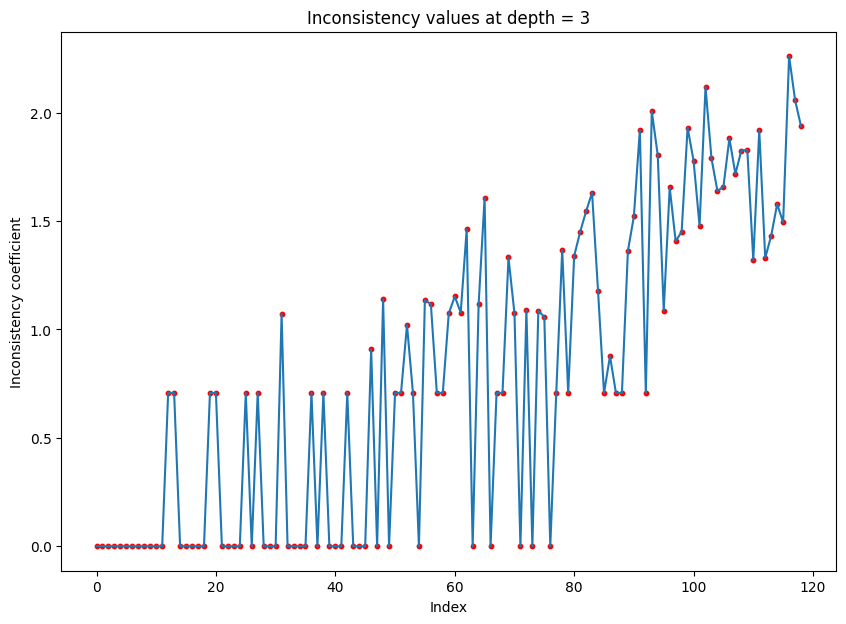

In [ ]:
# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))

plt.plot(incosistent_mtx[:,-1])
plt.scatter(
    range(incosistent_mtx.shape[0]),
    incosistent_mtx[:,-1],
    s=10, c='red'
)

plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [ ]:
#Threshold
thold = 4.5
#Cluster
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

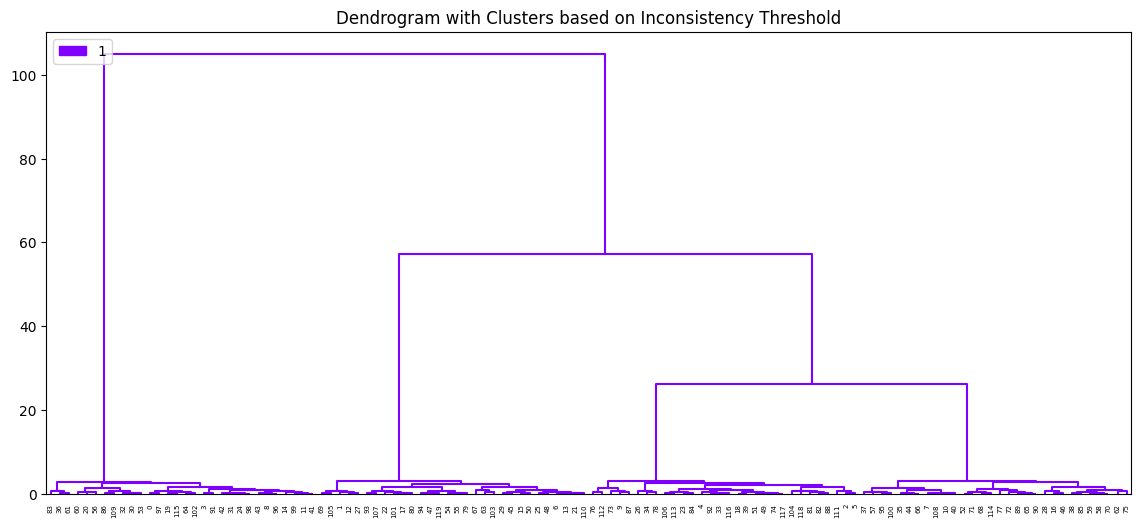

In [ ]:
# Get unique clusters
unique_clusters = np.unique(clusters)

# Get first two columns of linkage matrix (representing nodes in nodes)
trunc_linkage = linkage_matrix[:, :2].astype(np.int32)

# Get last "original" point ID
max_orig_point_id = df_hierarchical[['dim1', 'dim2']].shape[0]

# Initialize dict that will hold cluster-link relations
cluster_link_dict = {}

# Iterate through all the clusters
for clust in unique_clusters:

    # Get all points belonging to current cluster
    clust_points = np.where(clusters == clust)[0]

    # Iterate until we collect all nodes associated with current cluster
    while True:

        # Find all positions in linkage matrix where points from the current
        # cluster are present. These positions in linkage matrix also
        # denote IDs of merged nodes (merged node id = position in linkage mtx + max_orig_point_id)
        points_present = np.isin(trunc_linkage, clust_points)

        # Sum the matrix in order to find positions where
        # both points belong to current cluster
        present_points_sum = np.sum(points_present, axis=1)
        loc_of_twos = np.where(present_points_sum == 2)[0]

        # Get node locations
        nodes_to_add = list(loc_of_twos)

        # Variable that will be changed to True if new nodes are added to the dict
        added_new = False

        # Iterate through the node
        for node in nodes_to_add:

            # Get true ids of the nodes
            node_pos = node + max_orig_point_id

            # Add new nodes
            if node_pos not in cluster_link_dict:
                added_new = True
                cluster_link_dict[node_pos] = clust

        # If no new nodes are added, this means that all
        # nodes associated with current cluster are already added.
        # In this case break current loop and proceed to the next cluster.
        if not added_new:
            break

        # Add merged nodes for next iteration
        new_clust_points = loc_of_twos + max_orig_point_id
        clust_points = np.concatenate([clust_points, new_clust_points])

# Get color palette having one color per cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
# Transform colors to hex format (dendrogram function requires it)
colors_hex = [plt.matplotlib.colors.rgb2hex(c) for c in colors]

color_dict = {key: colors_hex[cluster_link_dict[key] - 1] for key in cluster_link_dict}

link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

patches = [
    mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i]))
    for i in range(len(colors_hex))
]

plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    link_color_func=link_color_func,
    orientation='top',
    labels=df_hierarchical.index
)
plt.legend(handles=patches, loc='upper left')
plt.title('Dendrogram with Clusters based on Inconsistency Threshold')
plt.show()

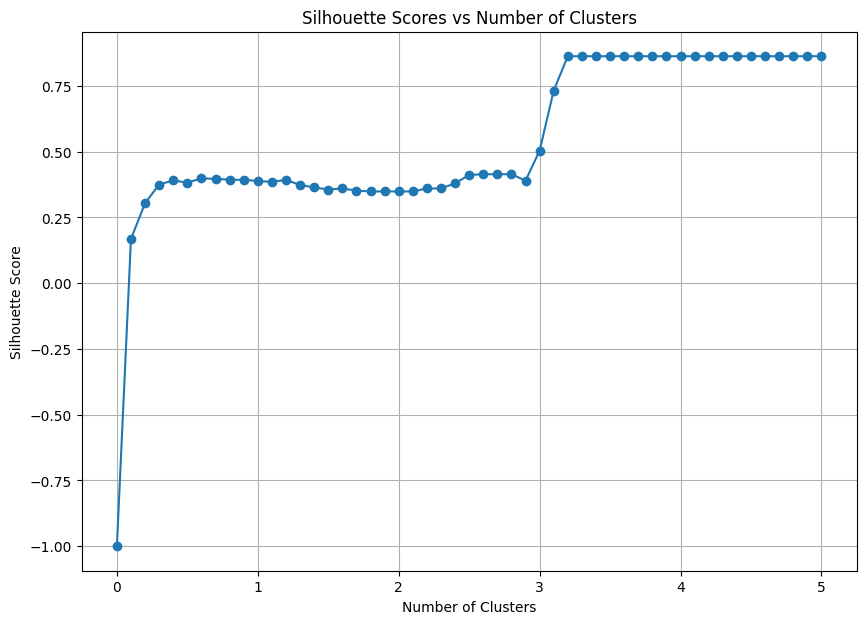

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Initialize list to store Silhouette Scores
silhouette_scores = []

# Range of threshold to test
thresholds = [i / 10 for i in range(51)]  # Thresholds from 0 to 5 in steps of 0.1

# Loop through each threshold and calculate Silhouette Score
for threshold in thresholds:
    clustering = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, linkage='ward')
    clusters = clustering.fit_predict(df_hierarchical[['dim1', 'dim2']])
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    if num_clusters > 1:  # Ensure there is more than one cluster
        if num_clusters == len(df_hierarchical):  # All points are in a single cluster
            silhouette_scores.append(-1)  # Silhouette score not applicable
        else:
            score = silhouette_score(df_hierarchical[['dim1', 'dim2']], clusters)
            silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # If only one cluster, Silhouette Score is not valid

# Plot Silhouette Scores vs Number of Clusters
plt.figure(figsize=(10, 7))
plt.plot(thresholds, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
depth=4
incosistent_mtx = inconsistent(linkage_matrix, depth)

In [ ]:
inconsistency_df = pd.DataFrame(
    incosistent_mtx,
    columns=['mean', 'std', 'num_links', 'inconsistency_coeff']
)
inconsistency_df.tail(10)

,mean,std,num_links,inconsistency_coeff
109,0.773791,0.662111,14.0,2.592082
110,1.132277,0.754312,10.0,1.893389
111,0.790237,0.784001,13.0,2.630399
112,1.211169,0.895146,10.0,1.891073
113,1.333738,0.933852,11.0,1.860300
114,1.072202,0.905921,12.0,2.220933
115,1.089569,0.927143,14.0,2.224069
116,3.254823,6.413772,15.0,3.575067
117,7.177556,15.213719,15.0,3.286265
118,14.997182,30.245094,14.0,2.976852


In [ ]:
linkage_df = pd.DataFrame(
    linkage_matrix,
    columns=['First group', 'Second group', 'Distance', 'Size']
)
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df.tail(10)

,First group,Second group,Distance,Size,New id
109,219.0,224.0,2.490037,27.0,229
110,199.0,227.0,2.560483,25.0,230
111,218.0,226.0,2.852473,19.0,231
112,207.0,229.0,2.903955,30.0,232
113,221.0,230.0,3.070983,30.0,233
114,204.0,228.0,3.084193,30.0,234
115,220.0,231.0,3.151599,30.0,235
116,233.0,235.0,26.184489,60.0,236
117,234.0,236.0,57.173873,90.0,237
118,232.0,237.0,105.032341,120.0,238


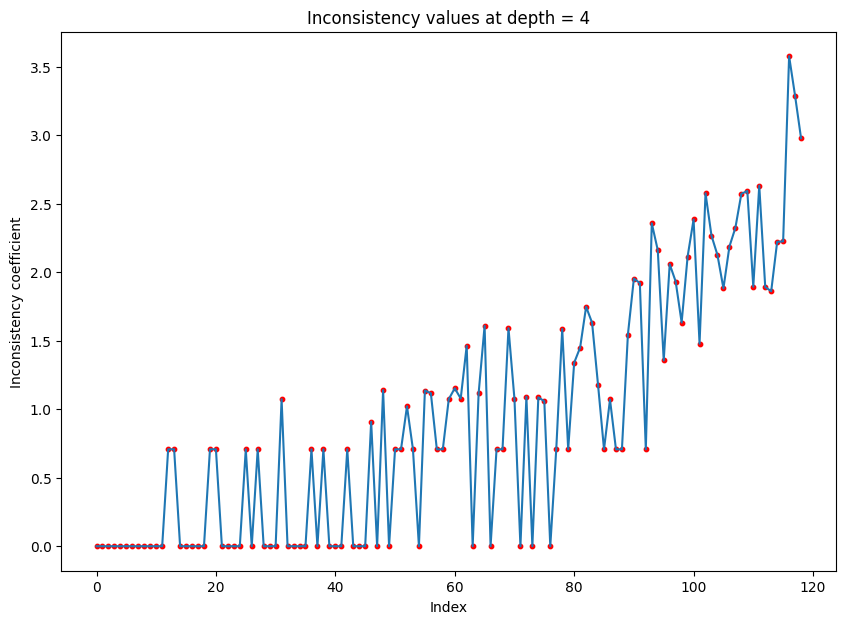

In [ ]:
# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))

plt.plot(incosistent_mtx[:,-1])
plt.scatter(
    range(incosistent_mtx.shape[0]),
    incosistent_mtx[:,-1],
    s=10, c='red'
)

plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [ ]:
#Threshold
thold = 4.5
#Cluster
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

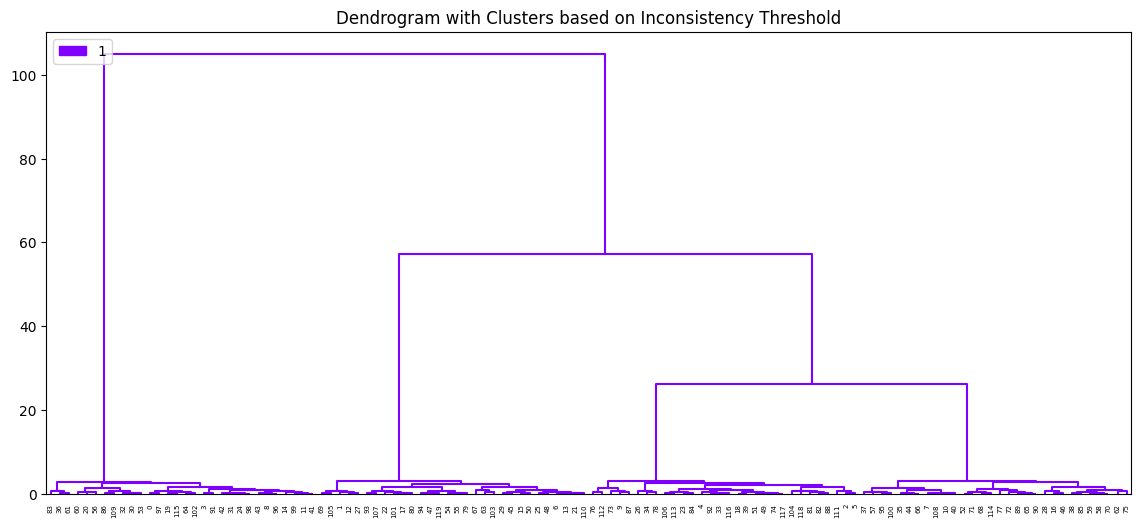

In [ ]:
# Get unique clusters
unique_clusters = np.unique(clusters)

# Get first two columns of linkage matrix (representing nodes in nodes)
trunc_linkage = linkage_matrix[:, :2].astype(np.int32)

# Get last "original" point ID
max_orig_point_id = df_hierarchical[['dim1', 'dim2']].shape[0]

# Initialize dict that will hold cluster-link relations
cluster_link_dict = {}

# Iterate through all the clusters
for clust in unique_clusters:

    # Get all points belonging to current cluster
    clust_points = np.where(clusters == clust)[0]

    # Iterate until we collect all nodes associated with current cluster
    while True:

        # Find all positions in linkage matrix where points from the current
        # cluster are present. These positions in linkage matrix also
        # denote IDs of merged nodes (merged node id = position in linkage mtx + max_orig_point_id)
        points_present = np.isin(trunc_linkage, clust_points)

        # Sum the matrix in order to find positions where
        # both points belong to current cluster
        present_points_sum = np.sum(points_present, axis=1)
        loc_of_twos = np.where(present_points_sum == 2)[0]

        # Get node locations
        nodes_to_add = list(loc_of_twos)

        # Variable that will be changed to True if new nodes are added to the dict
        added_new = False

        # Iterate through the node
        for node in nodes_to_add:

            # Get true ids of the nodes
            node_pos = node + max_orig_point_id

            # Add new nodes
            if node_pos not in cluster_link_dict:
                added_new = True
                cluster_link_dict[node_pos] = clust

        # If no new nodes are added, this means that all
        # nodes associated with current cluster are already added.
        # In this case break current loop and proceed to the next cluster.
        if not added_new:
            break

        # Add merged nodes for next iteration
        new_clust_points = loc_of_twos + max_orig_point_id
        clust_points = np.concatenate([clust_points, new_clust_points])

# Get color palette having one color per cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
# Transform colors to hex format (dendrogram function requires it)
colors_hex = [plt.matplotlib.colors.rgb2hex(c) for c in colors]

color_dict = {key: colors_hex[cluster_link_dict[key] - 1] for key in cluster_link_dict}

link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

patches = [
    mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i]))
    for i in range(len(colors_hex))
]

plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    link_color_func=link_color_func,
    orientation='top',
    labels=df_hierarchical.index
)
plt.legend(handles=patches, loc='upper left')
plt.title('Dendrogram with Clusters based on Inconsistency Threshold')
plt.show()

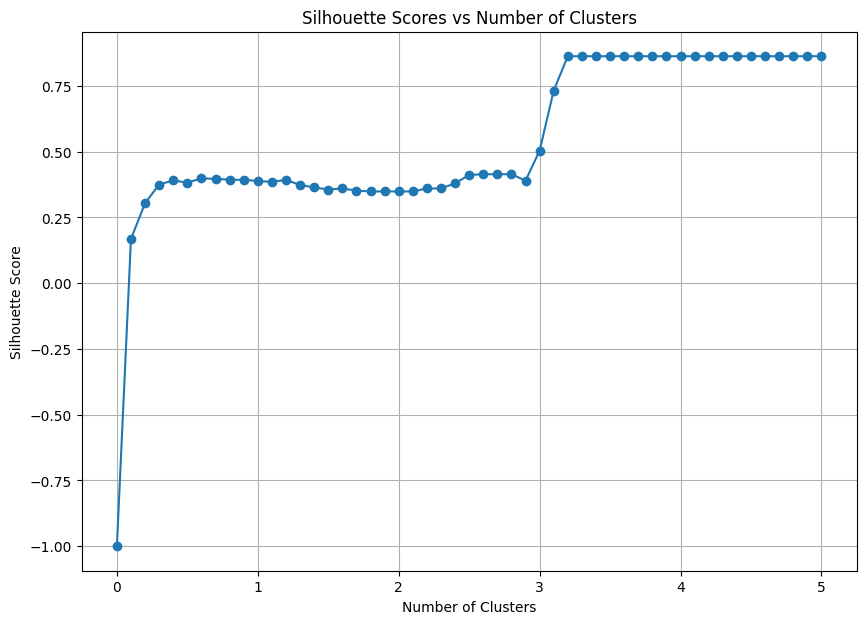

In [ ]:
# Initialize list to store Silhouette Scores
silhouette_scores = []

# Range of threshold to test
thresholds = [i / 10 for i in range(51)]  # Thresholds from 0 to 5 in steps of 0.1

# Loop through each threshold and calculate Silhouette Score
for threshold in thresholds:
    clustering = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, linkage='ward')
    clusters = clustering.fit_predict(df_hierarchical[['dim1', 'dim2']])
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    if num_clusters > 1:  # Ensure there is more than one cluster
        if num_clusters == len(df_hierarchical):  # All points are in a single cluster
            silhouette_scores.append(-1)  # Silhouette score not applicable
        else:
            score = silhouette_score(df_hierarchical[['dim1', 'dim2']], clusters)
            silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # If only one cluster, Silhouette Score is not valid

# Plot Silhouette Scores vs Number of Clusters
plt.figure(figsize=(10, 7))
plt.plot(thresholds, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
depth=5
incosistent_mtx = inconsistent(linkage_matrix, depth)

In [ ]:
inconsistency_df = pd.DataFrame(
    incosistent_mtx,
    columns=['mean', 'std', 'num_links', 'inconsistency_coeff']
)
inconsistency_df.tail(10)

,mean,std,num_links,inconsistency_coeff
109,0.641444,0.614267,19.0,3.009428
110,0.823323,0.722503,16.0,2.404364
111,0.667819,0.749396,16.0,2.915220
112,0.862140,0.808213,17.0,2.526333
113,1.163257,0.847506,15.0,2.250989
114,0.802945,0.797502,19.0,2.860490
115,0.734715,0.826437,24.0,2.924463
116,2.158060,4.982461,26.0,4.822201
117,4.245094,11.421083,28.0,4.634305
118,8.646437,22.911178,26.0,4.206938


In [ ]:
linkage_df = pd.DataFrame(
    linkage_matrix,
    columns=['First group', 'Second group', 'Distance', 'Size']
)
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df.tail(10)

,First group,Second group,Distance,Size,New id
109,219.0,224.0,2.490037,27.0,229
110,199.0,227.0,2.560483,25.0,230
111,218.0,226.0,2.852473,19.0,231
112,207.0,229.0,2.903955,30.0,232
113,221.0,230.0,3.070983,30.0,233
114,204.0,228.0,3.084193,30.0,234
115,220.0,231.0,3.151599,30.0,235
116,233.0,235.0,26.184489,60.0,236
117,234.0,236.0,57.173873,90.0,237
118,232.0,237.0,105.032341,120.0,238


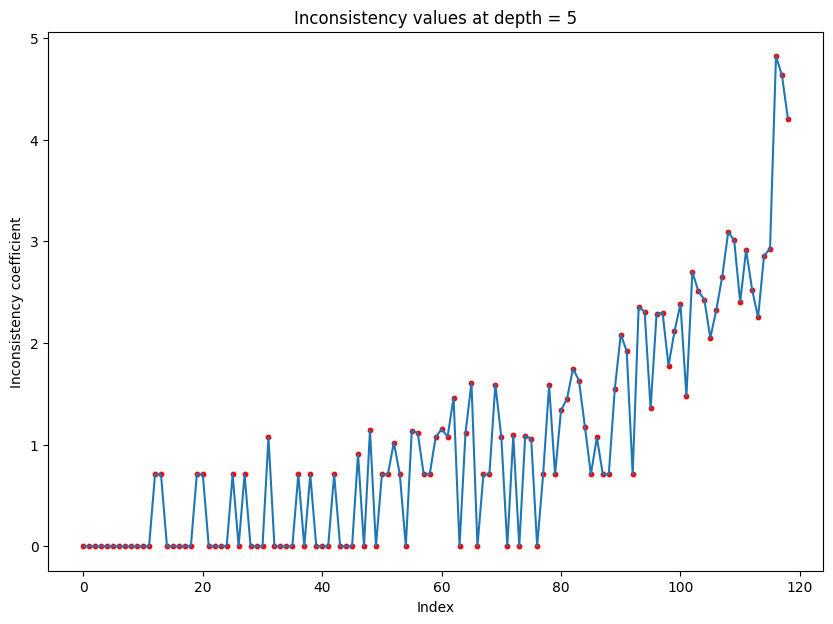

In [ ]:
# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))

plt.plot(incosistent_mtx[:,-1])
plt.scatter(
    range(incosistent_mtx.shape[0]),
    incosistent_mtx[:,-1],
    s=10, c='red'
)

plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [ ]:
#Threshold
thold = 4.5
#Cluster
clusters = fcluster(Z=linkage_matrix, t=thold, criterion='inconsistent', R=incosistent_mtx)

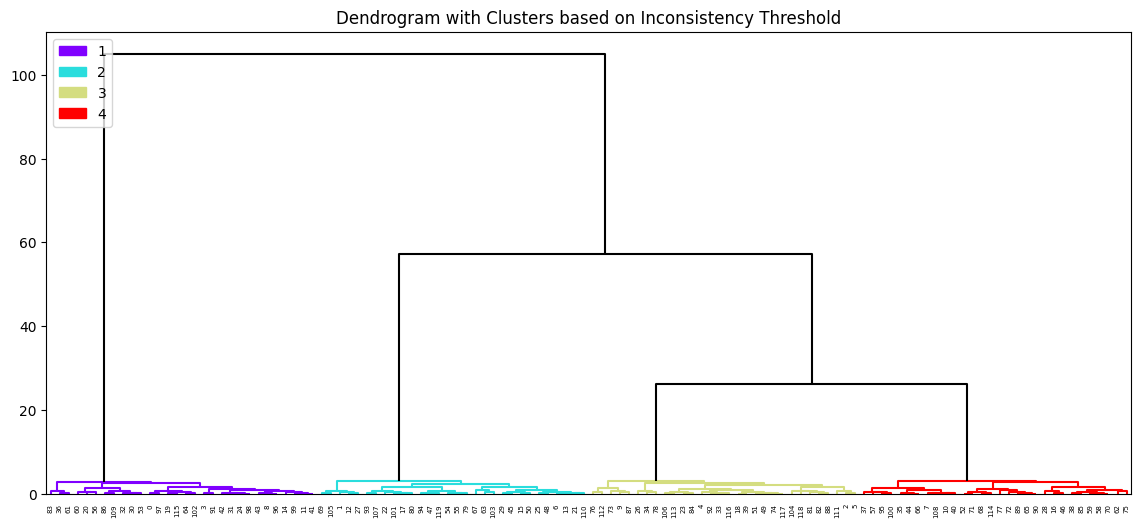

In [ ]:
# Get unique clusters
unique_clusters = np.unique(clusters)

# Get first two columns of linkage matrix (representing nodes in nodes)
trunc_linkage = linkage_matrix[:, :2].astype(np.int32)

# Get last "original" point ID
max_orig_point_id = df_hierarchical[['dim1', 'dim2']].shape[0]

# Initialize dict that will hold cluster-link relations
cluster_link_dict = {}

# Iterate through all the clusters
for clust in unique_clusters:

    # Get all points belonging to current cluster
    clust_points = np.where(clusters == clust)[0]

    # Iterate until we collect all nodes associated with current cluster
    while True:

        # Find all positions in linkage matrix where points from the current
        # cluster are present. These positions in linkage matrix also
        # denote IDs of merged nodes (merged node id = position in linkage mtx + max_orig_point_id)
        points_present = np.isin(trunc_linkage, clust_points)

        # Sum the matrix in order to find positions where
        # both points belong to current cluster
        present_points_sum = np.sum(points_present, axis=1)
        loc_of_twos = np.where(present_points_sum == 2)[0]

        # Get node locations
        nodes_to_add = list(loc_of_twos)

        # Variable that will be changed to True if new nodes are added to the dict
        added_new = False

        # Iterate through the node
        for node in nodes_to_add:

            # Get true ids of the nodes
            node_pos = node + max_orig_point_id

            # Add new nodes
            if node_pos not in cluster_link_dict:
                added_new = True
                cluster_link_dict[node_pos] = clust

        # If no new nodes are added, this means that all
        # nodes associated with current cluster are already added.
        # In this case break current loop and proceed to the next cluster.
        if not added_new:
            break

        # Add merged nodes for next iteration
        new_clust_points = loc_of_twos + max_orig_point_id
        clust_points = np.concatenate([clust_points, new_clust_points])

# Get color palette having one color per cluster
colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))
# Transform colors to hex format (dendrogram function requires it)
colors_hex = [plt.matplotlib.colors.rgb2hex(c) for c in colors]

color_dict = {key: colors_hex[cluster_link_dict[key] - 1] for key in cluster_link_dict}

link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

patches = [
    mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i]))
    for i in range(len(colors_hex))
]

plt.figure(figsize=(14, 6))
dendrogram(
    linkage_matrix,
    link_color_func=link_color_func,
    orientation='top',
    labels=df_hierarchical.index
)
plt.legend(handles=patches, loc='upper left')
plt.title('Dendrogram with Clusters based on Inconsistency Threshold')
plt.show()

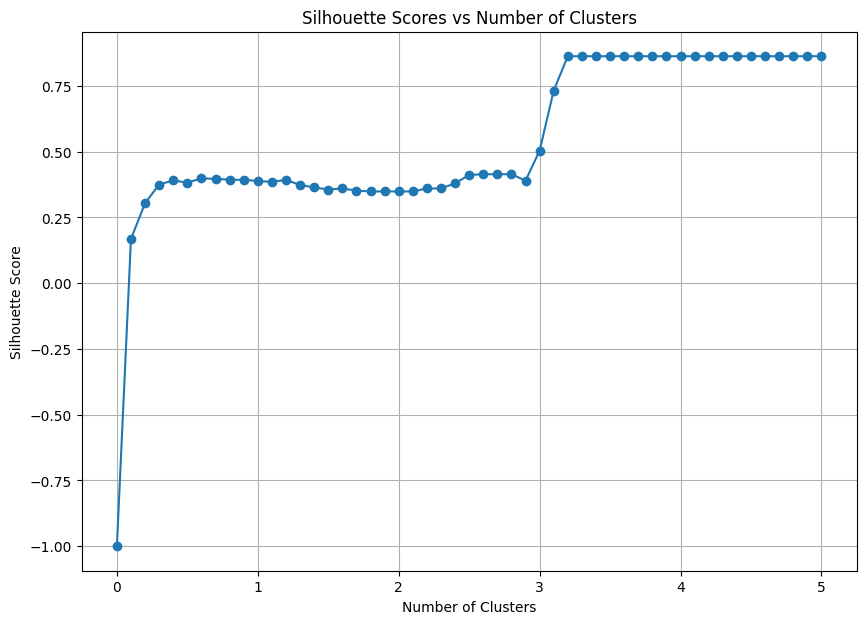

In [ ]:
# Initialize list to store Silhouette Scores
silhouette_scores = []

# Range of threshold to test
thresholds = [i / 10 for i in range(51)]  # Thresholds from 0 to 5 in steps of 0.1

# Loop through each threshold and calculate Silhouette Score
for threshold in thresholds:
    clustering = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, linkage='ward')
    clusters = clustering.fit_predict(df_hierarchical[['dim1', 'dim2']])
    unique_clusters = np.unique(clusters)
    num_clusters = len(unique_clusters)
    if num_clusters > 1:  # Ensure there is more than one cluster
        if num_clusters == len(df_hierarchical):  # All points are in a single cluster
            silhouette_scores.append(-1)  # Silhouette score not applicable
        else:
            score = silhouette_score(df_hierarchical[['dim1', 'dim2']], clusters)
            silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # If only one cluster, Silhouette Score is not valid

# Plot Silhouette Scores vs Number of Clusters
plt.figure(figsize=(10, 7))
plt.plot(thresholds, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

optimal parameter=5